In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import seaborn as sns

sns.set_context('talk')

## define the same random seed for future use
RND = 722
KFOLD_ITER = 5

**Note:**

Data source: [hotel demand datasets](https://ars.els-cdn.com/content/image/1-s2.0-S2352340918315191-mmc2.zip) from Antonio, et al. (2019).

Paper: Antonio, N., De Almeida, A., & Nunes, L. (2019). Hotel booking demand datasets. Data in Brief, 22, 41-49. https://doi.org/10.1016/j.dib.2018.11.126

**In this iteration, we use a similar dataset as iteration 1. The changes are on the algorithms and parameter configurations. We also remove StaysInWeekNights from the feature sets because it has a similar distribution both on the cancelled and non-cancelled bookings.**

# 5. Data Mining Method Selection

Supervised learning: classification task.


# 6. Data Mining Algorithm Selection

In iteration 2, we only use the top three performing models from iteration 1 & tune their parameters.
- Random Forest
- XGBoost
- Gradient-Boosted Decision Tree

In [2]:
## prepared & transformed:
df_hotel = pd.read_csv("hotel_merged_data_transformation.csv")

# 7. Data Mining

## 7.1. Create and Justify Test Designs

Train-validation-test. Use k-fold cross validation to estimate the performance in validation set.

In [3]:
## we have split the training and test data into 70:30 before feature selection and oversampling
## we use the same split
mask_train = (df_hotel['IsTrainSet'] == 1)
EXCLUDED_FEATURE_COLS = ['IsCanceled','IsTrainSet','StaysInWeekNights']
mask_feature_cols = df_hotel.columns[~(df_hotel.columns.isin(EXCLUDED_FEATURE_COLS))]

X_train = df_hotel[mask_train][mask_feature_cols]
y_train = df_hotel[mask_train]['IsCanceled']

X_test = df_hotel[~mask_train][mask_feature_cols]
y_test = df_hotel[~mask_train]['IsCanceled']

## 7.2. Conduct Data Mining

Algorithms:
- Random Forest
- XGBoost
- Gradient-Boosted Decision Tree

These models are evaluated based on accuracy and AUC.

In [4]:
from sklearn.metrics import accuracy_score, classification_report
from sklearn.metrics import roc_auc_score

def evaluate_performance(y_true, y_pred, print_results = True):
    accuracy = accuracy_score(y_true, y_pred)
    auc = roc_auc_score(y_true, y_pred)
    
    if print_results:
        print("Accuracy : {:,.3%}".format(accuracy))
        print("AUC: {:,.3f}".format(auc))
        print(classification_report(y_true, y_pred))
        
    return accuracy, auc

In [5]:
from sklearn.model_selection import KFold

def kfold_cv(clf, X_train, y_train, k = 10):
    kfold = KFold(random_state = RND, shuffle = True, n_splits = k)
    
    cv_accuracy = np.zeros(shape = k)
    cv_auc = np.zeros(shape = k)
    
    i = 0
    for train_index, val_index in kfold.split(X_train):
        X_tr = X_train.loc[train_index]
        y_tr = y_train.loc[train_index]
        X_val = X_train.loc[val_index]
        y_val = y_train.loc[val_index]
        
        clf.fit(X_tr, y_tr)
        y_pred = clf.predict(X_val)
        accuracy, auc = evaluate_performance(y_val, y_pred, print_results = False)
        
        cv_accuracy[i] = accuracy
        cv_auc[i] = auc
        
        i += 1
    
    print("Cross-validation results")
    print("========================")
    print("Accuracy: {:,.3%}".format(np.mean(cv_accuracy), np.std(cv_accuracy)))
    print("AUC: {:,.3f}".format(np.mean(cv_auc), np.std(cv_auc)))

### Random Forest

In [6]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(
    random_state = RND,
    max_features = 8,
    max_samples = 0.8,
    n_estimators = 150
)

## Perform k-fold cross-validation
kfold_cv(rf, X_train, y_train, k = KFOLD_ITER)

## Train with the whole training set
rf.fit(X_train, y_train)

Cross-validation results
Accuracy: 86.008%
AUC: 0.860


RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features=8,
                       max_leaf_nodes=None, max_samples=0.8,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=150,
                       n_jobs=None, oob_score=False, random_state=722,
                       verbose=0, warm_start=False)

In [7]:
y_pred = rf.predict(X_test)
accuracy, auc = evaluate_performance(y_test, y_pred)

Accuracy : 84.878%
AUC: 0.840
              precision    recall  f1-score   support

       False       0.88      0.87      0.88     22493
        True       0.79      0.81      0.80     13322

    accuracy                           0.85     35815
   macro avg       0.84      0.84      0.84     35815
weighted avg       0.85      0.85      0.85     35815



### XGBoost

In [8]:
from xgboost import XGBClassifier

xgb = XGBClassifier(
    random_state = RND,
    n_estimators = 150,
    colsample_bytree = 0.8,
    colsample_bynode = 0.8,
    learning_rate = 0.33,
    gamma = 0.02,
    subsample = 0.8
)

## Perform k-fold cross-validation
kfold_cv(xgb, X_train, y_train, k = KFOLD_ITER)

## Train with the whole training set
xgb.fit(X_train, y_train)

Cross-validation results
Accuracy: 83.253%
AUC: 0.833


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=0.8, colsample_bytree=0.8, gamma=0.02, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.33, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=150, n_jobs=0, num_parallel_tree=1,
              objective='binary:logistic', random_state=722, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=1, subsample=0.8,
              tree_method='exact', validate_parameters=1, verbosity=None)

In [9]:
y_pred = xgb.predict(X_test)
accuracy, auc = evaluate_performance(y_test, y_pred)

Accuracy : 82.278%
AUC: 0.815
              precision    recall  f1-score   support

       False       0.87      0.85      0.86     22493
        True       0.75      0.78      0.77     13322

    accuracy                           0.82     35815
   macro avg       0.81      0.81      0.81     35815
weighted avg       0.82      0.82      0.82     35815



### GBDT

In [10]:
import lightgbm as lgbm

gbdt = lgbm.LGBMClassifier(
    random_state = RND,
    colsample_bytree = 0.8,
    learning_rate = 0.3,
    objective = 'binary',
    reg_lambda = 0.1,
    n_estimators = 300,
    num_leaves = 500 # 300 # 200 # 100
)

## Perform k-fold cross-validation
kfold_cv(gbdt, X_train, y_train, k = KFOLD_ITER)

## Train with the whole training set
gbdt.fit(X_train, y_train)

Cross-validation results
Accuracy: 86.442%
AUC: 0.864


LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=0.8,
               importance_type='split', learning_rate=0.3, max_depth=-1,
               min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
               n_estimators=300, n_jobs=-1, num_leaves=500, objective='binary',
               random_state=722, reg_alpha=0.0, reg_lambda=0.1, silent=True,
               subsample=1.0, subsample_for_bin=200000, subsample_freq=0)

In [11]:
y_pred = gbdt.predict(X_test)
accuracy, auc = evaluate_performance(y_test, y_pred)

Accuracy : 84.347%
AUC: 0.833
              precision    recall  f1-score   support

       False       0.88      0.87      0.88     22493
        True       0.79      0.79      0.79     13322

    accuracy                           0.84     35815
   macro avg       0.83      0.83      0.83     35815
weighted avg       0.84      0.84      0.84     35815



## 7.3. Search for Patterns

### Random Forest

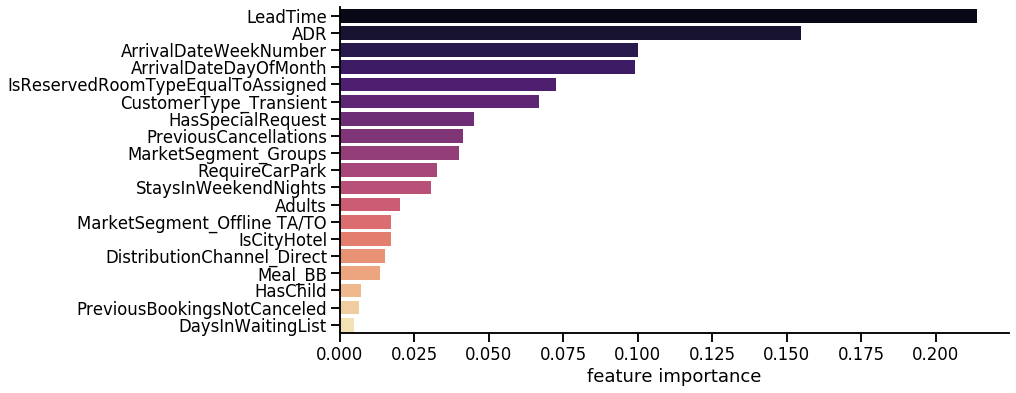

In [12]:
rf_features = pd.DataFrame(
    data = {
        'feature_name': X_train.columns,
        'feature_importance': rf.feature_importances_
    }
).sort_values(by='feature_importance', ascending=False)

f, ax = plt.subplots(figsize = (12,6))
sns.barplot(
    data = rf_features,
    y = 'feature_name',
    x = 'feature_importance',
    orient = 'h',
    palette = 'magma',
    ax = ax
);

plt.xlabel('feature importance')
plt.ylabel('')
sns.despine();

### XGBoost

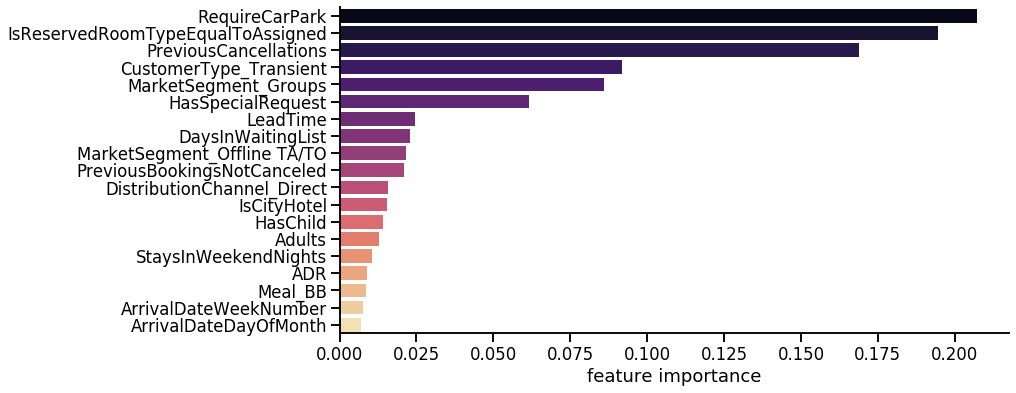

In [13]:
xgb_features = pd.DataFrame(
    data = {
        'feature_name': X_train.columns,
        'feature_importance': xgb.feature_importances_
    }
).sort_values(by='feature_importance', ascending=False)

f, ax = plt.subplots(figsize = (12,6))
sns.barplot(
    data = xgb_features,
    y = 'feature_name',
    x = 'feature_importance',
    orient = 'h',
    palette = 'magma',
    ax = ax
);

plt.xlabel('feature importance')
plt.ylabel('')
sns.despine();

### GBDT

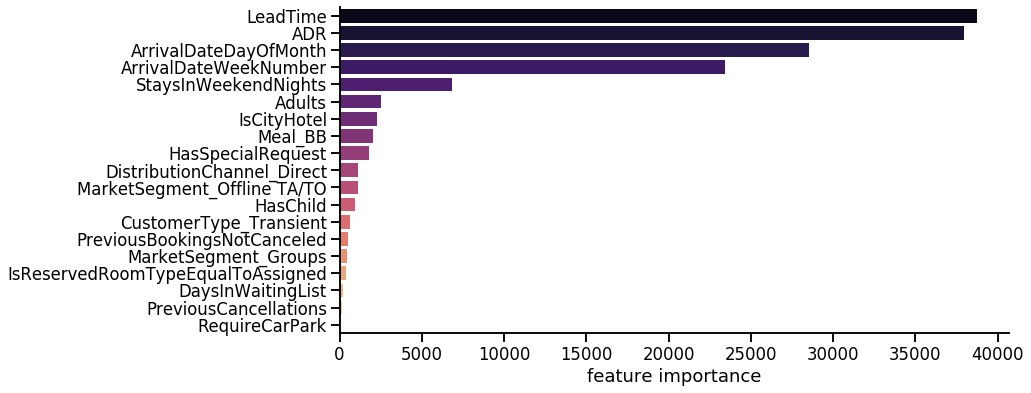

In [14]:
gbdt_features = pd.DataFrame(
    data = {
        'feature_name': X_train.columns,
        'feature_importance': gbdt.feature_importances_
    }
).sort_values(by='feature_importance', ascending=False)

f, ax = plt.subplots(figsize = (12,6))
sns.barplot(
    data = gbdt_features,
    y = 'feature_name',
    x = 'feature_importance',
    orient = 'h',
    palette = 'magma',
    ax = ax
);

plt.xlabel('feature importance')
plt.ylabel('')
sns.despine();

# 8. Interpretation

## 8.1. Study and Discuss the Mined Patterns


In [15]:
TOP_N_FEATURES = 5
FEATURE_NAME_COL = 'feature_name'

df_top_features = pd.DataFrame(
    data = {
        'random_forest': rf_features.head(TOP_N_FEATURES)[FEATURE_NAME_COL].values,
        'xgboost': xgb_features.head(TOP_N_FEATURES)[FEATURE_NAME_COL].values,
        'gbdt': gbdt_features.head(TOP_N_FEATURES)[FEATURE_NAME_COL].values
    }
)

df_top_features

,random_forest,xgboost,gbdt
0,LeadTime,RequireCarPark,LeadTime
1,ADR,IsReservedRoomTypeEqualToAssigned,ADR
2,ArrivalDateWeekNumber,PreviousCancellations,ArrivalDateDayOfMonth
3,ArrivalDateDayOfMonth,CustomerType_Transient,ArrivalDateWeekNumber
4,IsReservedRoomTypeEqualToAssigned,MarketSegment_Groups,StaysInWeekendNights


In [16]:
from itertools import chain

top_features = set(chain(*df_top_features.values))
top_features

{'ADR',
 'ArrivalDateDayOfMonth',
 'ArrivalDateWeekNumber',
 'CustomerType_Transient',
 'IsReservedRoomTypeEqualToAssigned',
 'LeadTime',
 'MarketSegment_Groups',
 'PreviousCancellations',
 'RequireCarPark',
 'StaysInWeekendNights'}

## 8.2. Visualise the Data, Results, Models, Patterns

Note: we only visualise `StaysInWeekendNights` since it is a new feature (cf. Iteration 1).

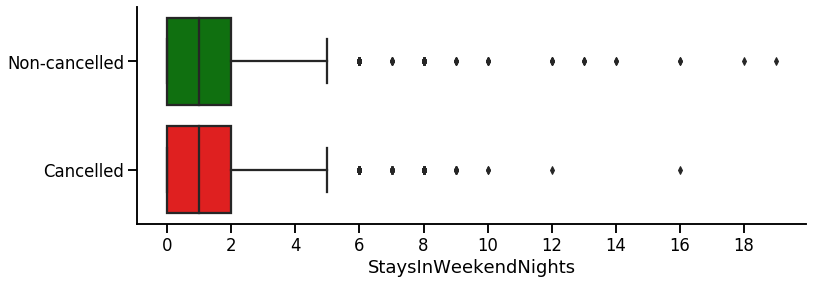

In [17]:
f, ax = plt.subplots(figsize = (12, 4))

sns.boxplot(
    data = df_hotel,
    x = 'StaysInWeekendNights',
    y = 'IsCanceled',
    orient = 'h',
    palette = ['green', 'red'],
    ax = ax
)

ax.set_xticks(np.arange(0,20,2))
ax.set_ylabel('')
ax.set_yticklabels(labels = ['Non-cancelled', 'Cancelled'])
sns.despine();

Visualise CustomerType and MarketSegment based on IsCanceled.

In [18]:
df_pretransformed = pd.read_csv('hotel_merged_data_preparation.csv')

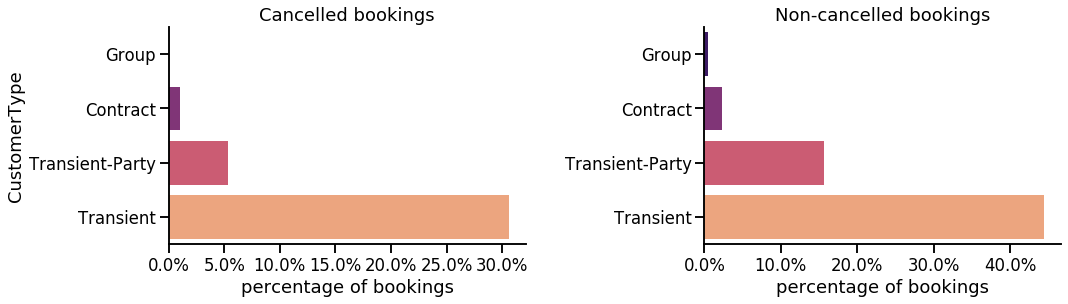

In [19]:
d = df_pretransformed.groupby([
    'CustomerType',
    'IsCanceled'
]).agg({
    'LeadTime': 'count'
}).reset_index().rename(
    columns = {
        'LeadTime': 'count'
    }
)

d['pct'] = d['count'] / np.sum(d['count'])

## plotting
f, ax = plt.subplots(figsize = (16, 4), ncols = 2)
plt.subplots_adjust(wspace = .5)

sns.barplot(
    data = d[(d['IsCanceled'] == True)].sort_values(by = 'pct'),
    x = 'pct',
    y = 'CustomerType',
    palette = 'magma',
    ax = ax[0]
)
ax[0].set_title('Cancelled bookings')
ax[0].xaxis.set_major_formatter(mtick.PercentFormatter(1.0))
ax[0].set_xlabel('percentage of bookings')

sns.barplot(
    data = d[(d['IsCanceled'] == False)].sort_values(by = 'pct'),
    x = 'pct',
    y = 'CustomerType',
    palette = 'magma',
    ax = ax[1]
)
ax[1].set_title('Non-cancelled bookings')
ax[1].xaxis.set_major_formatter(mtick.PercentFormatter(1.0))
ax[1].set_xlabel('percentage of bookings')
ax[1].set_ylabel('')

sns.despine();

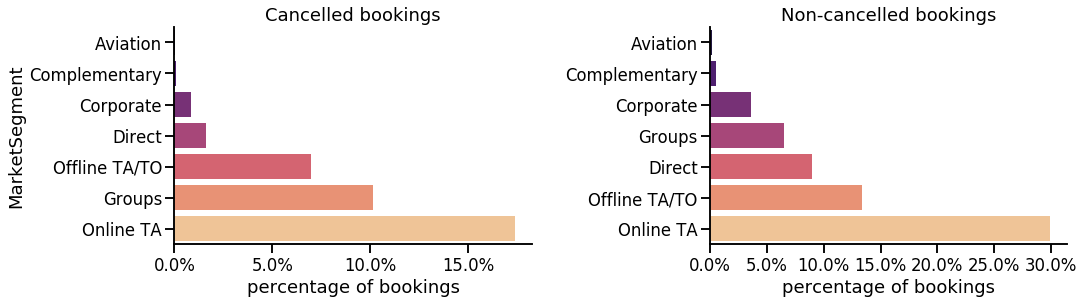

In [20]:
d = df_pretransformed.groupby([
    'MarketSegment',
    'IsCanceled'
]).agg({
    'LeadTime': 'count'
}).reset_index().rename(
    columns = {
        'LeadTime': 'count'
    }
)

d['pct'] = d['count'] / np.sum(d['count'])

## plotting
f, ax = plt.subplots(figsize = (16, 4), ncols = 2)
plt.subplots_adjust(wspace = .5)

sns.barplot(
    data = d[(d['IsCanceled'] == True)].sort_values(by = 'pct'),
    x = 'pct',
    y = 'MarketSegment',
    palette = 'magma',
    ax = ax[0]
)
ax[0].set_title('Cancelled bookings')
ax[0].set_xlabel('percentage of bookings')
ax[0].xaxis.set_major_formatter(mtick.PercentFormatter(1.0))

sns.barplot(
    data = d[(d['IsCanceled'] == False)].sort_values(by = 'pct'),
    x = 'pct',
    y = 'MarketSegment',
    palette = 'magma',
    ax = ax[1]
)
ax[1].set_title('Non-cancelled bookings')
ax[1].xaxis.set_major_formatter(mtick.PercentFormatter(1.0))
ax[1].set_xlabel('percentage of bookings')
ax[1].set_ylabel('')

sns.despine();

## 8.3. Interpret the Results, Models, Patterns

...

## 8.4. Assess and Evaluate the Results, Models, Patterns

In [21]:
from sklearn.metrics import plot_roc_curve

def display_roc_curve(clfs, X, y, axis = None):
    for clf in clfs:
        plot_roc_curve(
            clf,
            X,
            y,
            ax = axis
        )

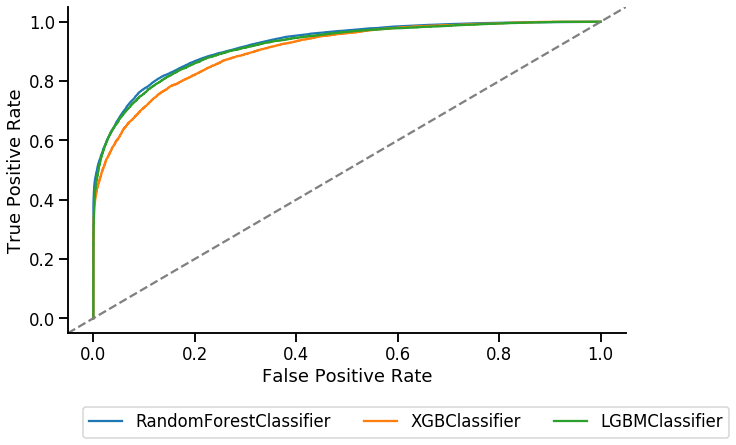

In [22]:
f, ax = plt.subplots(figsize = (10, 6))

clfs = [rf, xgb, gbdt]
display_roc_curve(
    clfs, 
    X_test,
    y_test,
    axis = ax
)

ax.plot(
    [0, 1], 
    [0, 1], 
    transform = ax.transAxes,
    linestyle = 'dashed',
    color = 'grey'
)

plt.legend(
    bbox_to_anchor = [1.2, -0.2],
    ncol = 3,
    labels = [
        clf.__class__.__name__ for clf in clfs
    ]
)

sns.despine();